# Beta diversity

In [3]:
import qiime2 as q2
import biom
from biom import load_table, Table
from biom.util import biom_open
import pandas as pd
from qiime2.plugins.deicode.actions import rpca
from qiime2.plugins.emperor.actions import biplot
from skbio import OrdinationResults
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
import plotnine as pn
%matplotlib inline

## Import data

In [4]:
bt = load_table('/Users/swandro/Documents/Projects/Seed_Grants/Nash/data/16s/original/deblur150.biom')
md = pd.read_csv('/Users/swandro/Documents/Projects/Seed_Grants/Nash/data/metadata/10781_20190528-121437.txt', sep='\t', index_col=0)

taxa=q2.Artifact.load("taxonomy.qza")
taxa_df = pd.read_csv("taxonomy.tsv",sep='\t', index_col=0)
taxa_df.index.name = "feature-id"

## Format data

In [5]:
#Collapse to genus
genus_dict = {name:{"genus":row.Taxon.split("; s__")[0]} for name,row in taxa_df.iterrows()}

In [6]:
#Keep only WT and Qa- samples
samples_keep = set(md.query('description in ["WT","Qa-1-/-"]').index) & set(bt.ids("sample"))
bt.filter(samples_keep, inplace=True)

#Min sample count 500
bt = bt.filter(bt.ids("sample")[bt.sum("sample") > 500], inplace=True)
#Min feature count 10
bt = bt.filter(ids_to_keep=bt.ids("observation")[bt.sum("observation") > 10], axis="observation", inplace=True)

#Collapse to genus
bt.add_metadata(genus_dict, axis="observation")
bin_f = lambda id_, x: x['genus']
bt_genus = bt.collapse(bin_f, norm=False, axis="observation")


## Beta diversity

In [8]:
#Import to qiime2
qza = q2.Artifact.import_data('FeatureTable[Frequency]', bt_genus)
q2_md = q2.Metadata(md.apply(axis=0, func=lambda x:[str(y) for y in x]))
q2_tax = q2.Metadata(taxa_df)
#Run Deicode
bplt,dm = rpca(qza)


In [9]:
DM = dm.view(DistanceMatrix)

In [10]:
permanova(DM, grouping=md, column="strain_genotype")

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     123
number of groups                  2
test statistic              73.5356
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

In [11]:
genus_df = pd.DataFrame([x.split(";")[-1].strip() if x.split(";")[-1] != " g__" else ";".join(x.split(";")[-2:]).strip() for x in bt_genus.ids("observation")],bt_genus.ids("observation"))
genus_df.columns=["short_name"]
genus_df.index.name = "feature-id"
genus_df
genus_q2_md = q2.Metadata(genus_df)

In [16]:
genus_ord = bplt.view(OrdinationResults)

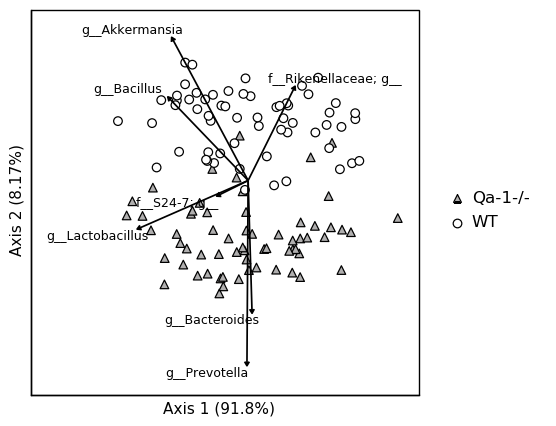

<ggplot: (376388167)>

In [17]:
pn.options.figure_size = (5,5)

plot_dat = genus_ord.samples
plot_dat.columns=["axis1","axis2","axis3"]
plot_dat = plot_dat.merge(md, right_index=True, left_index=True)

feature_df = genus_ord.features.copy()
feature_df.columns=["axis1","axis2","axis3"]
feature_df["tot"] = feature_df.apply(axis=1, func=lambda x: sum([abs(y) for y in x]))
feature_df = feature_df.sort_values("tot", ascending=False)
feature_df = feature_df.iloc[:7,:]
feature_df["short_name"] = [x.split(";")[-1].strip() if x.split(";")[-1] != " g__" else ";".join(x.split(";")[-2:]).strip() for x in feature_df.index]
name_df = feature_df.copy()
name_df["axis1"] = [row.axis1/2 -.06 if row.short_name!="f__Rikenellaceae; g__" else row.axis1/2 +.06 for name,row in name_df.iterrows()]
name_df["axis2"] = [row.axis2/2 -.01 if row.axis2 < 0 else row.axis2/2 +.01 for name,row in name_df.iterrows()]

p = (pn.ggplot(data = plot_dat) +
    pn.geom_point( pn.aes(x ="axis1", y="axis2", shape="strain_genotype", fill= "strain_genotype"),stroke=.5, size=3) +
    pn.geom_segment( data=feature_df, mapping=pn.aes(x=0, y=0, xend ="axis1/2", yend="axis2/2"), arrow=pn.geoms.arrow(length=.06, type="closed"), size=.7) +
    pn.geom_text( data=name_df, mapping=pn.aes(x="axis1", y="axis2", label="short_name"), size=9) +
    pn.scale_y_continuous(limits=[-.27,.21]) + 
     pn.scale_shape_manual(name=" ", labels=["Qa-1-/-","WT"],values=["^","o"]) +
     pn.scale_fill_manual(name=" ", labels=["Qa-1-/-","WT"],values=["#B0AFAF","white"]) +
     pn.scale_x_continuous(limits=[-.30,.23]) +
     pn.labs(x="Axis 1 ({}%)".format(round(genus_ord.proportion_explained[0]*100,2)),
            y="Axis 2 ({}%)".format(round(genus_ord.proportion_explained[1]*100,2)),
            shape='') +
     pn.theme_classic() +
     pn.theme(
         axis_text = pn.element_blank(),
         panel_background = pn.element_rect(size=1, color="black", fill=None),
         axis_ticks = pn.element_blank(),
         legend_text = pn.element_text(size=12)
     )
    )

p.save("16S_biplot.pdf", dpi=300)
p

In [43]:
#Import to qiime2
qza = q2.Artifact.import_data('FeatureTable[Frequency]', bt_genus)
q2_md = q2.Metadata(md.apply(axis=0, func=lambda x:[str(y) for y in x]))
#Run Deicode
bplt,dm = rpca(qza)
#Make biplot
genus_bplt_viz = biplot(biplot=bplt,
                  sample_metadata=q2_md,
                        #feature_metadata=genus_q2_md,
                 number_of_features=5).visualization

In [44]:
genus_bplt_viz

<visualization: Visualization uuid: 5dac5845-8a53-4af5-8e47-6eeb8ca5e55f>

## Subset only shared ASVs

#### Get set of shared ASVs

In [114]:
#Get samples to keep
wt_samples = set(md.query('description=="WT"').index) & set(bt_f.ids("sample"))
qa1_samples = set(md.query('description=="Qa-1-/-"').index) & set(bt_f.ids("sample"))

bt_wt = bt_f.filter(ids_to_keep=wt_samples, inplace=False)
bt_wt.filter(ids_to_keep= bt_wt.ids("observation")[bt_wt.sum("observation") > 0], axis="observation", inplace=True)

bt_qa1 = bt_f.filter(ids_to_keep=qa1_samples, inplace=False)
bt_qa1.filter(ids_to_keep= bt_qa1.ids("observation")[bt_qa1.sum("observation") > 0], axis="observation", inplace=True)

#Get shared ASVs
shared_asvs = set(bt_wt.ids("observation")) & set(bt_qa1.ids("observation"))



In [115]:
print("WT ASVs:", len(bt_wt.ids("observation")))
print("Qa1 ASVs:", len(bt_qa1.ids("observation")))
print("Shared:",len(shared_asvs))

WT ASVs: 534
Qa1 ASVs: 609
Shared: 407


In [118]:
#Filter to only shared
bt_shared = bt_f.filter(ids_to_keep=shared_asvs, axis="observation", inplace=False)
qza_shared= q2.Artifact.import_data('FeatureTable[Frequency]', bt_shared)

bplt_shared,dm_shared = rpca(qza_shared)
#Make biplot
bplt_viz_shared = biplot(biplot=bplt_shared,
                  sample_metadata=q2_md,
                  feature_metadata=q2_tax,
                 number_of_features=10).visualization

/anaconda3/envs/qiime2/lib/python3.6/site-packages/biom/table.py:4049: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  for r in self.matrix_data.tocsr()]
/anaconda3/envs/qiime2/lib/python3.6/site-packages/biom/table.py:4052: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return constructor(mat, index=index, columns=columns)
/anaconda3/envs/qiime2/lib/python3.6/site-packages/pandas/core/sparse/frame.py:854: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pyd

In [121]:
bt_f

736 x 123 <class 'biom.table.Table'> with 21295 nonzero entries (23% dense)

In [122]:
bt_shared

407 x 123 <class 'biom.table.Table'> with 16380 nonzero entries (32% dense)